# Загрузка и импорт необходимых библиотек

In [ ]:
!pip install geopandas
!pip install haversine
!pip install catboost
!pip install bayesian-optimization

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

from os.path import join

from shapely import wkb
from datetime import timedelta

import geopandas as gpd
from sklearn.neighbors import BallTree

from haversine import haversine
from math import sqrt, cos, acos, degrees

from google.colab import files

from bayes_opt import BayesianOptimization
import catboost as cat
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [ ]:
data_dir = '/content/drive/My Drive/CODD/data'

In [ ]:
!ls '/content/drive/My Drive/CODD/data'

 bus_stops.csv		      repairs_overlaps.csv   test_data.csv
 cameras.csv		      road_graph.csv	     train.csv
 crossroad_angle.csv	      road_network_2.csv     velo.csv
 data.csv		      road_network.csv	    'Граф дорог Москвы (1).csv'
 isk_dorozh_nerov.csv	      svetofor.csv	     Задача.txt
 mean_speeds_on_cameras.csv   test.csv		    'Описание данных.xlsx'


Проанализировав описание данных, принял решение выжать максимум из тех данных, что предоставили организаторы. Хотя рассматривал варианты использования открытых данных с сайта mos.ru.

In [ ]:
train = pd.read_csv(join(data_dir, 'train.csv'))
test = pd.read_csv(join(data_dir, 'test.csv'))
road_graph = pd.read_csv(join(data_dir, 'road_graph.csv'), sep=';')
road_network = pd.read_csv(join(data_dir, 'road_network.csv'), sep=';')
repairs = pd.read_csv(join(data_dir, 'repairs_overlaps.csv'), sep=';')
cameras = pd.read_csv(join(data_dir, 'cameras.csv'), sep=';')
speeds = pd.read_csv(join(data_dir, 'mean_speeds_on_cameras.csv'), sep=';',  decimal=',')

# Анализ таргета

Распределение количества пострадавших на участках дорог оказалось ожидаемо несбалансированным, что нужно будет учесть при обучении модели и получении результатов.

In [ ]:
train = train.fillna(0)

In [ ]:
victims_distribution = train.groupby('victims').id.count().values
victims_distribution

array([834700,  30538,   6522,   2173,    775,    416,    238,    126,
           26,     31,      6,     14,      2,      3,      1,      2,
            7,      1,     10,      3,      2])

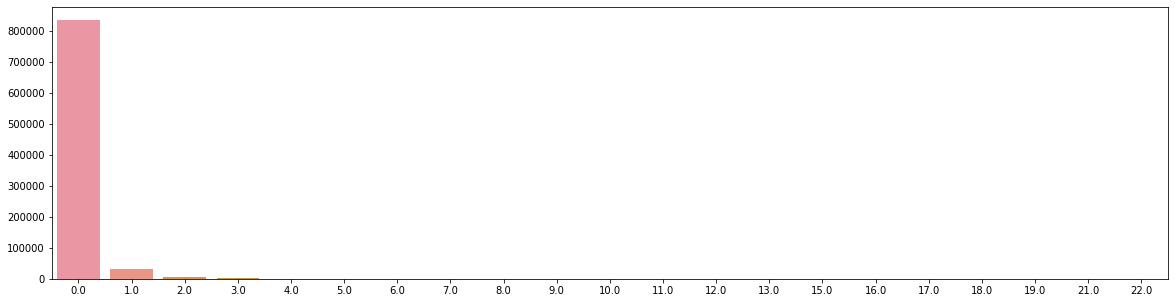

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(train.victims.unique()[0:], victims_distribution[0:], ax=ax)

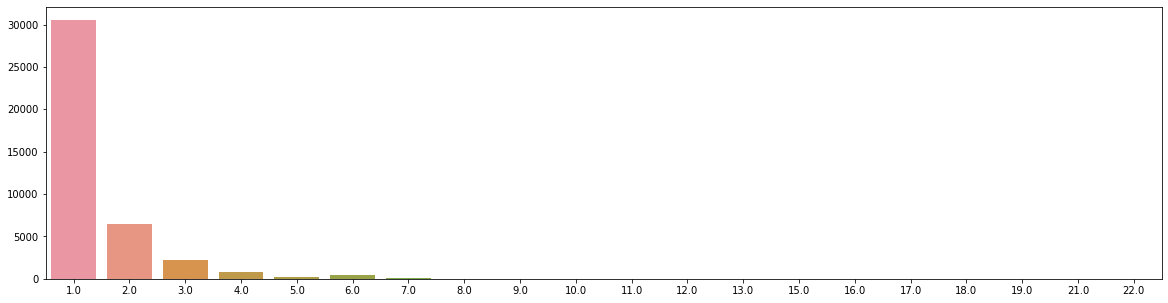

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(train.victims.unique()[1:], victims_distribution[1:], ax=ax)

**Совпадения id в трейне и тесте**

Также было найдено пересечени тестовых и тренировочных id. Использование таких ликов нежелательно, но это может помочь существенно улучшить метрики.

In [ ]:
train[(train.id.isin(test.id.values))].drop_duplicates('id')

,id,victims
39045,17178985,1.0
40281,1079733,0.0
40372,533730,0.0
40430,12025556,0.0
40478,19048542,0.0
...,...,...
845555,14552532,0.0
845995,14552454,2.0
849118,14552631,0.0
852114,12379303,0.0


# Объединение train и test

Трейн и тест объединяются с созданием дополнительного признака, к какому множеству отностится объект.

In [ ]:
train['is_test'] = 0
test['is_test'] = 1

In [ ]:
data = pd.concat([train, test])

In [ ]:
del train
del test

# Приведение геометрий к правильному типу

Геометрия приводится к типу geometry для дальнейшего использования.

In [ ]:
def to_geom(x):
    return wkb.loads(x.strip(), hex=True)

In [ ]:
road_graph.geom = road_graph.geom.apply(to_geom)

In [ ]:
road_graph = road_graph.drop(['geom_buffer'], axis=1)

In [ ]:
for i in range(repairs.shape[0]):
    try:
        repairs.geom[i] = to_geom(repairs.geom[i].strip())
    except:
        repairs = repairs[~repairs.index.isin([i])]

ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string
ParseException: Premature end of HEX string


# Начало, середина и конец участка

Безсуловно, важными признаками являются географические признаки. Они непосредственно определяют расположение участка дороги, а также помогут в выведении других фичей.

In [ ]:
lon_start = []
lat_start = []
lon_end = []
lat_end = []

for i in tqdm(range(len(road_graph.geom))):
    x = np.array(road_graph.geom[i].geoms[0].coords.xy, dtype=float)[0]
    y = np.array(road_graph.geom[i].geoms[0].coords.xy, dtype=float)[1]
    lon_start.append(x[0])
    lat_start.append(y[0])
    lon_end.append(x[len(x)-1])
    lat_end.append(y[len(y)-1])

road_graph['lat_start'] = lat_start
road_graph['lon_start'] = lon_start
road_graph['lat_end'] = lat_end
road_graph['lon_end'] = lon_end

In [ ]:
road_graph['lon_mean'] = (road_graph.lon_start + road_graph.lon_end) / 2
road_graph['lat_mean'] = (road_graph.lat_start + road_graph.lat_end) / 2

In [ ]:
road_graph.head(1)

,id,geom,obj_cod,typ_cod,nlevel,btf,oneway,surface,splitter,speedlim,f_rspeed,t_rspeed,lanewidth,f_lanes,t_lanes,f_sidewalk,t_sidewalk,f_buslanes,t_buslanes,multidigit,rd_name,rd_e_name,rd_l_name,f_parking,t_parking,bicyclanes,lat_start,lon_start,lat_end,lon_end,lon_mean,lat_mean
0,14644059,(LINESTRING (36.80456837166526 55.440413298899...,4011775,7730,1,0,0,3,2,77,40,40,0,1,1,0,0,0,0,0,NaN,NaN,NaN,0,1,0,55.440413,36.804568,55.465773,36.701662,36.753115,55.453093


# Длина и кривизна участка

Длина участка влияет на вероятность попадания дтп на этот участок.

Также вывел фичу кривизны, которая показывает сложность участка. Геометрию разбил на последовательные вектора, посчитал косинус угла между ними, и, благодаря свойству косинуса, чем больше суммарный угол, тем больше кривизна участка.

In [ ]:
road_graph['kriv'] = 0
road_graph['dist'] = 0

In [ ]:
for j in tqdm(range(len(road_graph.geom))):
    x = np.array(road_graph.geom[j].geoms[0].coords.xy, dtype=float)[0]
    y = np.array(road_graph.geom[j].geoms[0].coords.xy, dtype=float)[1]
    
    angle = 0
    dist = 0
    k = 1
    for i in range(len(x)-2):
        a = [x[i+1] - x[i], y[i+1] - y[i]]
        b = [x[i+2] - x[i+1], y[i+2] - y[i+1]] 
        angle_step = (a[0] * b[0] + a[1] * b[1]) / (sqrt(a[0]**2 + a[1]**2) * sqrt(b[0]**2 + b[1]**2))
        angle += angle_step    
    for i in range(len(x) - 1):
        dist += haversine((y[i], x[i]), (y[i+1], x[i+1]))
    road_graph['dist'].iloc[j] = dist
    road_graph['kriv'].iloc[j] = angle

# Соединение data и road_graph

In [ ]:
data = pd.merge(data, road_graph, on='id', how='left')

# Добавление камер и скоростей с них

Важным признаком является наличие камер на дороге, так как камеры являются методом успокоения трафика. 

Задачу нахождения камер, принадлежащих участку, решал алгоритмом поиска ближайших соседей из sklearn - BallTree.

In [ ]:
data_gpd = gpd.GeoDataFrame([{
        'id': id,
        'x': a,
        'y': b,
    } for id, a, b in zip(np.array(data.id), np.array(data.lat_start + data.lat_end)/2, np.array(data.lon_start + data.lon_end)/2)
])

cameras_gpd = gpd.GeoDataFrame([{
        'x': a,
        'y': b,
    } for a, b in zip(np.array(cameras.x), np.array(cameras.y))
])

In [ ]:
tree = BallTree(cameras_gpd[['x', 'y']].values, leaf_size=2)

In [ ]:
data_gpd['distance_nearest'], data_gpd['id_nearest'] = tree.query(
    data_gpd[['x', 'y']].values, # The input array for the query
    k=1, # The number of nearest neighbors
)

In [ ]:
cameras_done = data_gpd[data_gpd.distance_nearest < 0.001].reset_index(drop=True)
cameras_done['camera'] = np.nan

In [ ]:
for i in range(len(cameras_done.camera)):
    cameras_done.camera.iloc[i] = cameras.camera[cameras_done.id_nearest[i]]

In [ ]:
cameras_done = cameras_done[['id', 'camera']]
cameras_done.head(1)

,id,camera
0,1467902,36012


Около 10% ДТП случались из-за **нарушения скоростного режима**. По этой причине было грех не добавить признак скоростей с камер, тем более, что у нас есть данные по скоростным ограничениям на участках.

In [ ]:
cameras_done['speed_day'] = np.nan
cameras_done['speed_night'] = np.nan

In [ ]:
for i in tqdm(range(len(cameras_done.camera))):
    try:
        cameras_done.speed_day.iloc[i] = speeds[(speeds.camera_id == cameras_done.camera[i])&(speeds.time_of_day == 'day')].avg_check_speed.values[0]
        cameras_done.speed_night.iloc[i] = speeds[(speeds.camera_id == cameras_done.camera[i])&(speeds.time_of_day == 'night')].avg_check_speed.values[0]
    except:
        pass

In [ ]:
data = pd.merge(data, cameras_done.drop_duplicates(['id']), on='id', how='left')

# Удаление ненужных столбцов из данных

Удалили столбцы названий дорог.

In [ ]:
data.columns

Index(['id', 'victims', 'is_test', 'geom', 'obj_cod', 'typ_cod', 'nlevel',
       'btf', 'oneway', 'surface', 'splitter', 'speedlim', 'f_rspeed',
       't_rspeed', 'lanewidth', 'f_lanes', 't_lanes', 'f_sidewalk',
       't_sidewalk', 'f_buslanes', 't_buslanes', 'multidigit', 'rd_name',
       'rd_e_name', 'rd_l_name', 'f_parking', 't_parking', 'bicyclanes',
       'lat_start', 'lon_start', 'lat_end', 'lon_end', 'lon_mean', 'lat_mean',
       'kriv', 'dist', 'camera', 'speed_day', 'speed_night'],
      dtype='object')

In [ ]:
data = data.drop(['rd_name', 'rd_e_name', 'rd_l_name'], axis=1)

# Добавление информации из road_network

Фактически, датасет road_network содержит в себе агрегированные данные, которые можно найти на том же mos.ru. (Спасибо организаторам, что собрали всё в один файлик!)

Тут есть очень важные фичи: **пешеходные переходы** (на них приходится 11% ДТП), а также **светофоры**, которые являются признаками перекрестка и способом успокоения трафика.

In [ ]:
data['bus_stop_net'] = 0
data['tram_stop_net'] = 0
data['traf_lights_net'] = 0
data['zebra_net'] = 0
data['under_zebra_net'] = 0
data['over_zebra_net'] = 0
data['danger_net'] = 0

In [ ]:
for i in tqdm(range(road_network.shape[0])):
    id_temp = road_network.EDGEID.iloc[i]
    type_temp = road_network.TYP_COD.iloc[i]
    if type_temp == 7813:
        data.loc[data.id == id_temp, 'bus_stop_net'] = 1
    elif type_temp == 7814:
        data.loc[data.id == id_temp, 'tram_stop_net'] = 1
    elif type_temp == 7816:
        data.loc[data.id == id_temp, 'traf_lights_net'] = 1
    elif type_temp == 7817:
        data.loc[data.id == id_temp, 'zebra_net'] = 1
    elif type_temp == 7818:
        data.loc[data.id == id_temp, 'under_zebra_net'] = 1
    elif type_temp == 7819:
        data.loc[data.id == id_temp, 'over_zebra_net'] = 1
    elif type_temp == 7821:
        data.loc[data.id == id_temp, 'danger_net'] = 1

# Добавление перекрытий на дорогах

Ремотные работы и перекрытия создают сложности на дорогах, так как зачастую занимают одну или несколько полос. Лично много раз наблюдал аварии из-за перекрытых дорог.

In [ ]:
for i in range(len(repairs.start_date)):

    try:
        pd.to_datetime(repairs.start_date.iloc[i])
    except:
        print(repairs.start_date.iloc[i]) 

###############################################################################################################################################################################################################################################################


In [ ]:
repairs = repairs[~(repairs.start_date == '###############################################################################################################################################################################################################################################################')]

In [ ]:
repairs = repairs.reset_index(drop=True)

In [ ]:
repairs.last_update = pd.to_datetime(repairs.last_update)
repairs.start_date = pd.to_datetime(repairs.start_date)
repairs.end_date = pd.to_datetime(repairs.end_date)

Добавил признак **длительности ремонта**. Перекрытие на 1 день с меньшей вероятностью станет причиной аварии, нежели перекрытие на несколько дней.

In [ ]:
repairs['duration'] = 0

for i in tqdm(range(repairs.shape[0])):

    repairs.duration.iloc[i] = (repairs.end_date.iloc[i] - repairs.start_date.iloc[i]).days

Добавл One-Hot encoding для признака вида перекрытия: ремонтные работы или мероприятие.

In [ ]:
rep_type = pd.get_dummies(repairs.type)
rep_type.columns = ['events', 'repair_work']
rep_type.head(1)

,events,repair_work
0,0,1


In [ ]:
repairs = pd.merge(repairs, rep_type, on=repairs.index)

In [ ]:
repairs = repairs.rename(columns={'key_0': 'id_nearest'})

In [ ]:
repairs[['events', 'repair_work']] = repairs[['events', 'repair_work']].astype(int)

Добавил географические признаки для перекрытий. 

In [ ]:
lon_r_start = []
lat_r_start = []
lon_r_end = []
lat_r_end = []

for i in tqdm(range(len(repairs.geom))):
    x = np.array(repairs.geom[i].coords.xy[0], dtype=float)
    y = np.array(repairs.geom[i].coords.xy[1], dtype=float)
    lon_r_start.append(x[0])
    lat_r_start.append(y[0])
    lon_r_end.append(x[len(x)-1])
    lat_r_end.append(y[len(y)-1])

repairs['lon_start'] = lon_r_start
repairs['lat_start'] = lat_r_start
repairs['lon_end'] = lon_r_end
repairs['lat_end'] = lat_r_end

Нашел ближайшие перекрытия тем же методом, что и камеры.

In [ ]:
data_gpd = gpd.GeoDataFrame([{
        'id': id,
        'x': a,
        'y': b,
    } for id, a, b in zip(np.array(data.id), np.array(data.lat_start + data.lat_end)/2, np.array(data.lon_start + data.lon_end)/2)
])

repairs_gpd = gpd.GeoDataFrame([{
        'x': a,
        'y': b,
    } for a, b in zip(np.array(repairs.lat_start + repairs.lat_end)/2, np.array(repairs.lon_start + repairs.lon_end)/2)
])

In [ ]:
tree = BallTree(repairs_gpd[['x', 'y']].values, leaf_size=2)

In [ ]:
data_gpd['distance_nearest'], data_gpd['id_nearest'] = tree.query(
    data_gpd[['x', 'y']].values, # The input array for the query
    k=1, # The number of nearest neighbors
)

In [ ]:
repairs = repairs[~(repairs.duration < 0)]

In [ ]:
data_gpd = pd.merge(data_gpd, repairs[['id_nearest', 'duration', 'events', 'repair_work']], on='id_nearest', how='left')

In [ ]:
data_gpd = data_gpd[data_gpd.distance_nearest < 0.001]
data_gpd.head(1)

,id,x,y,distance_nearest,id_nearest,duration,events,repair_work
403,19541612,55.416654,36.85237,0.000615,2479,NaN,NaN,NaN


В главный датасет добавил признак наличия ремонтных работ.

In [ ]:
data['repair'] = 0

In [ ]:
repair_ids = np.array(data_gpd.id)

In [ ]:
data.loc[data.id.isin(repair_ids), 'repair'] = 1

In [ ]:
data.head(1)

,id,victims,is_test,geom,obj_cod,typ_cod,nlevel,btf,oneway,surface,splitter,speedlim,f_rspeed,t_rspeed,lanewidth,f_lanes,t_lanes,f_sidewalk,t_sidewalk,f_buslanes,t_buslanes,multidigit,f_parking,t_parking,bicyclanes,lat_start,lon_start,lat_end,lon_end,lon_mean,lat_mean,kriv,dist,camera,speed_day,speed_night,bus_stop_net,tram_stop_net,traf_lights_net,zebra_net,under_zebra_net,over_zebra_net,danger_net,repair
0,14644059,0.0,0,(LINESTRING (36.80456837166526 55.440413298899...,4011775,7730,1,0,0,3,2,77,40,40,0,1,1,0,0,0,0,0,0,1,0,55.440413,36.804568,55.465773,36.701662,36.753115,55.453093,80.926906,7.754766,NaN,NaN,NaN,0,0,0,0,0,0,0,0


Объдинение с data.

In [ ]:
data_gpd = data_gpd.drop_duplicates(['id']) 

In [ ]:
data = pd.merge(data, data_gpd[['id', 'duration', 'events', 'repair_work']], on='id', how='left')

# Добавление информации о перекрестках

Почти 20% аварий происходит из-за **несоблюдения очередности при проезде перекрестков**. По этой причине решил, что информация о перекрестках является обязательной.

Способ достаточно прост. Находим несколько ближайших ребер и проверяем, что их угол пересечения лежит в диапазоне от 45 до 135. Диапазон можно менять, но решил остаться на этом варианте.

In [ ]:
find_nearest = data[['id', 'lat_mean', 'lon_mean']]
find_nearest.head(1)

,id,lat_mean,lon_mean
0,14644059,55.453093,36.753115


In [ ]:
tree = BallTree(find_nearest[['lat_mean', 'lon_mean']].values, leaf_size=2)

In [ ]:
distance_nearest, idx_nearest = tree.query(data[['lat_mean', 'lon_mean']].values, k=50)

In [ ]:
distance_nearest = pd.DataFrame(distance_nearest)
distance_nearest.columns = ['dist_near_{}'.format(x) for x in distance_nearest.columns]
distance_nearest = distance_nearest.drop(['dist_near_0'], axis=1)

In [ ]:
idx_nearest = pd.DataFrame(idx_nearest)
idx_nearest.columns = ['idx_near_{}'.format(x) for x in idx_nearest.columns]
idx_nearest = idx_nearest.drop(['idx_near_0'], axis=1)

Получил датасет с дистанциями и индексами ближайших участков.

In [ ]:
road_nearest = pd.DataFrame()

for i in range(distance_nearest.shape[1]):
    road_nearest[distance_nearest.columns[i]] = distance_nearest[distance_nearest.columns[i]]
    road_nearest[idx_nearest.columns[i]] = idx_nearest[idx_nearest.columns[i]]

road_nearest.head()

,dist_near_1,idx_near_1,dist_near_2,idx_near_2,dist_near_3,idx_near_3,dist_near_4,idx_near_4,dist_near_5,idx_near_5,dist_near_6,idx_near_6,dist_near_7,idx_near_7,dist_near_8,idx_near_8,dist_near_9,idx_near_9,dist_near_10,idx_near_10,dist_near_11,idx_near_11,dist_near_12,idx_near_12,dist_near_13,idx_near_13,dist_near_14,idx_near_14,dist_near_15,idx_near_15,dist_near_16,idx_near_16,dist_near_17,idx_near_17,dist_near_18,idx_near_18,dist_near_19,idx_near_19,dist_near_20,idx_near_20,...,dist_near_30,idx_near_30,dist_near_31,idx_near_31,dist_near_32,idx_near_32,dist_near_33,idx_near_33,dist_near_34,idx_near_34,dist_near_35,idx_near_35,dist_near_36,idx_near_36,dist_near_37,idx_near_37,dist_near_38,idx_near_38,dist_near_39,idx_near_39,dist_near_40,idx_near_40,dist_near_41,idx_near_41,dist_near_42,idx_near_42,dist_near_43,idx_near_43,dist_near_44,idx_near_44,dist_near_45,idx_near_45,dist_near_46,idx_near_46,dist_near_47,idx_near_47,dist_near_48,idx_near_48,dist_near_49,idx_near_49
0,0.038865,1,0.052304,2,0.053060,6,0.053949,7,0.054607,4,0.054827,3,0.056456,5,0.058680,8,0.059730,15,0.059947,18,0.060270,12,0.060270,13,0.060654,9,0.060856,11,0.061151,19,0.061587,22,0.061591,24,0.061591,25,0.061609,27,0.061698,14,...,0.063567,40,0.064519,30,0.064645,43,0.064901,36,0.064977,45,0.065128,46,0.065498,48,0.065524,50,0.065558,49,0.065558,35,0.065572,54,0.065655,52,0.065660,53,0.065679,20,0.065694,56,0.065718,55,0.065752,38,0.065825,62,0.065868,64,0.065999,57
1,0.038865,0,0.054976,33,0.062400,29,0.064883,28,0.065721,13,0.065721,12,0.065976,2,0.066456,24,0.066456,25,0.066581,15,0.066749,6,0.066878,22,0.067002,23,0.067149,18,0.067194,27,0.067571,7,0.067668,19,0.068004,21,0.068080,3,0.068497,4,...,0.070255,45,0.070269,46,0.070465,43,0.070558,62,0.070973,55,0.070988,64,0.071041,54,0.071188,50,0.071260,63,0.071299,53,0.071380,49,0.071491,56,0.071577,57,0.071606,68,0.071620,8,0.071736,69,0.071824,52,0.071898,48,0.072120,67,0.072226,51
2,0.000804,6,0.001704,7,0.002525,3,0.002556,4,0.004342,5,0.006412,8,0.008383,9,0.008873,11,0.009480,14,0.011528,18,0.011860,15,0.012414,30,0.012705,36,0.012969,19,0.013403,35,0.013558,38,0.013620,20,0.013889,13,0.013889,12,0.013977,21,...,0.015082,23,0.015134,26,0.015213,24,0.015213,25,0.015818,16,0.015836,43,0.015860,48,0.015891,44,0.016188,52,0.016452,49,0.016571,56,0.016585,50,0.016617,45,0.016703,53,0.016813,54,0.016860,46,0.016962,51,0.016999,57,0.017057,74,0.017128,55
3,0.000952,7,0.001074,4,0.001778,6,0.002032,5,0.002525,2,0.003900,8,0.005865,9,0.006464,11,0.006977,14,0.009933,30,0.010200,36,0.010289,18,0.010739,15,0.010906,35,0.011052,38,0.011188,20,0.011661,19,0.012506,17,0.012637,21,0.012665,10,...,0.013495,16,0.013537,22,0.013743,26,0.013928,23,0.014026,48,0.014147,25,0.014147,24,0.014194,43,0.014381,52,0.014537,74,0.014717,49,0.014827,56,0.014881,50,0.014972,80,0.014990,53,0.015038,45,0.015139,54,0.015145,51,0.015191,65,0.015265,57
4,0.000943,7,0.001074,3,0.001760,6,0.001855,5,0.002556,2,0.004100,8,0.006062,9,0.006366,11,0.007091,14,0.009965,30,0.010303,36,0.010979,35,0.011156,38,0.011338,18,0.011728,20,0.011799,15,0.012382,10,0.012614,17,0.012699,19,0.013266,16,...,0.014372,42,0.014591,22,0.014697,74,0.014764,26,0.014942,48,0.014980,23,0.015070,65,0.015122,80,0.015164,43,0.015206,25,0.015206,24,0.015211,61,0.015305,52,0.015470,71,0.015476,81,0.015486,73,0.015486,60,0.015661,49,0.015705,77,0.015769,56


In [ ]:
# 892 893 - пересекающиеся, почти перпендикулярные дороги, с пострадавшими

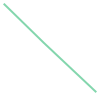

In [ ]:
data.geom[892]

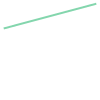

In [ ]:
data.geom[893]

**Функция вычисления угла между векторами.**

In [ ]:
def cos_vec(l_s_1, lo_s_1, l_e_1, lo_e_1,
            l_s_2, lo_s_2, l_e_2, lo_e_2):
    a = [l_e_1 - l_s_1, lo_e_1 - lo_s_1]
    b = [l_e_2 - l_s_2, lo_e_2 - lo_s_2] 
    if ((a[0] * b[0] + a[1] * b[1]) / (sqrt(a[0]**2 + a[1]**2) * sqrt(b[0]**2 + b[1]**2))) > 1:
        return degrees(acos(1))
    if (a[0] * b[0] + a[1] * b[1]) / (sqrt(a[0]**2 + a[1]**2) * sqrt(b[0]**2 + b[1]**2)) < -1:
        return degrees(acos(-1))
    return degrees(acos((a[0] * b[0] + a[1] * b[1]) / (sqrt(a[0]**2 + a[1]**2) * sqrt(b[0]**2 + b[1]**2))))

In [ ]:
from math import acos, degrees

In [ ]:
a = cos_vec(data.lat_end[892], data.lon_end[892], data.lat_start[892], data.lon_start[892],
    data.lat_start[893], data.lon_start[893], data.lat_end[893], data.lon_end[893])

In [ ]:
a

58.672382011426215

**Добавление информации о ближайших участках к трейну.**

In [ ]:
road_nearest = road_nearest[distance_nearest.dist_near_1 < 0.001]

In [ ]:
def cross_angle(row):
    data_indx = row[len(row)-1]
    j = 0
    a_max = 0
    while j < len(row)-1 and row[j] < 0.001:
        near_indx = int(row[j+1])
        a = cos_vec(data.lat_start[data_indx], data.lon_start[data_indx], data.lat_end[data_indx], data.lon_end[data_indx],
                    data.lat_start[near_indx], data.lon_start[near_indx], data.lat_end[near_indx], data.lon_end[near_indx])
        if 45 <= a <= 90:
            if a > a_max:
                a_max = a
        if 90 < a <= 135:
            if 180 - a > a_max:
                a_max = a
        j += 2
    
    return a_max

In [ ]:
# road_nearest['id'] = road_nearest.index

In [ ]:
# road_nearest['crossroad_angle'] = road_nearest.apply(cross_angle, axis=1)

In [ ]:
# road_nearest[['id', 'crossroad_angle']].to_csv('crossroad_angle.csv')
# files.download('crossroad_angle.csv')

Здесь код закомментирован, так как road_nearest.apply() выполняется довольно долго. Я просто сохранил результат в файл и загружаю его для дальнейшей работы.

In [ ]:
crossroad_angle = pd.read_csv(data_dir + '/crossroad_angle.csv', index_col=0)

In [ ]:
crossroad_angle.loc[crossroad_angle.crossroad_angle > 90, 'crossroad_angle'] = \
    180 - crossroad_angle.loc[crossroad_angle.crossroad_angle > 90, 'crossroad_angle']

In [ ]:
crossroad_angle['is_crossroad'] = 0
crossroad_angle.loc[crossroad_angle.crossroad_angle > 0, 'is_crossroad'] = 1

In [ ]:
data = pd.merge(data, crossroad_angle, on='id', how='left')

In [ ]:
data[data.crossroad_angle > 0].head()

,id,victims,is_test,geom,obj_cod,typ_cod,nlevel,btf,oneway,surface,splitter,speedlim,f_rspeed,t_rspeed,lanewidth,f_lanes,t_lanes,f_sidewalk,t_sidewalk,f_buslanes,t_buslanes,multidigit,f_parking,t_parking,bicyclanes,lat_start,lon_start,lat_end,lon_end,lon_mean,lat_mean,kriv,dist,camera,speed_day,speed_night,bus_stop_net,tram_stop_net,traf_lights_net,zebra_net,under_zebra_net,over_zebra_net,danger_net,repair,duration,events,repair_work,crossroad_angle,is_crossroad
346,162845,0.0,0,(LINESTRING (36.84757368875651 55.418239023616...,1070452,7700,3,0,0,2,1,60,60,60,0,1,1,0,0,0,0,0,0,0,0,55.418239,36.847574,55.416777,36.852117,36.849845,55.417508,4.975166,0.337902,NaN,NaN,NaN,1,0,0,0,0,0,0,0,NaN,NaN,NaN,79.723924,1.0
491,23382,1.0,0,(LINESTRING (36.86021846452731 55.429594532166...,1106436,7700,1,0,0,2,1,90,75,75,0,2,2,0,0,0,0,0,0,0,0,55.429595,36.860218,55.428917,36.859042,36.859630,55.429256,0.000000,0.105777,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,85.451812,1.0
524,175580,1.0,0,(LINESTRING (36.86108470995578 55.430102873359...,1106436,7700,1,0,0,2,1,60,60,60,0,2,2,0,0,0,0,0,0,0,0,55.430103,36.861085,55.429654,36.860319,36.860702,55.429878,0.999979,0.069520,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,84.276563,1.0
2022,151582,0.0,0,(LINESTRING (36.90128629521374 55.734304963253...,0,7700,6,0,0,5,0,60,15,15,0,1,1,0,0,0,0,0,0,0,0,55.734305,36.901286,55.736265,36.910978,36.906132,55.735285,14.740132,0.672571,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,79.068114,1.0
2211,414884,0.0,0,(LINESTRING (36.91097803915108 55.736265214810...,0,7700,6,0,0,2,1,90,25,25,0,1,1,0,0,0,0,0,0,0,0,55.736265,36.910978,55.740033,36.906787,36.908883,55.738149,10.065067,0.575774,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,88.731281,1.0


# Приведение к правильным типам данных. Удаление лишних колонок.

Удаление признаков, имеющих всего 1 уникальное значение.

In [ ]:
for col in data.columns:
    if data[col].dtype != object and data[col].nunique() < 2:
        print(col, data[col].nunique())

In [ ]:
data = data.drop(['under_zebra_net', 'over_zebra_net', 'danger_net', 'lanewidth'], axis=1)

Приведение категориальных признаков к типу int.

In [ ]:
for col in data.columns:
    if data[col].dtype != object and data[col].nunique() >= 2 and data[col].nunique() < 20:
        print(col, data[col].nunique())

is_test 2
typ_cod 8
nlevel 6
btf 15
oneway 3
surface 10
splitter 5
speedlim 15
f_rspeed 11
t_rspeed 11
f_lanes 11
t_lanes 5
f_sidewalk 9
t_sidewalk 9
f_buslanes 2
t_buslanes 2
multidigit 2
f_parking 7
t_parking 6
bicyclanes 4
camera 2
bus_stop_net 2
tram_stop_net 2
traf_lights_net 2
zebra_net 2
repair 2
events 2
repair_work 2
is_crossroad 2
dangerous 2


In [ ]:
categorical_columns = ['typ_cod', 'nlevel', 'btf', 'oneway',
                       'surface', 'splitter', 'f_sidewalk',
                       't_sidewalk', 'f_buslanes', 't_buslanes', 
                       'multidigit', 'f_parking', 't_parking', 
                       'bicyclanes', 'bus_stop_net',
                       'tram_stop_net', 'traf_lights_net',
                       'zebra_net', 'repair', 'events', 'repair_work',
                       'is_crossroad','dangerous']

In [ ]:
data[[c for c in data.columns if c in categorical_columns]] = data[[c for c in data.columns if c in categorical_columns]].astype(int)

In [ ]:
data = data.drop(['geom'], axis=1)

In [ ]:
data.loc[data.camera.notnull(), 'camera'] = 1
data.loc[data.camera.isnull(), 'camera'] = 0

In [ ]:
data[['camera', 'events', 'repair_work', 'is_crossroad']] \
    = data[['camera', 'events', 'repair_work', 'is_crossroad']].fillna(0)
data[['camera', 'events', 'repair_work', 'is_crossroad']] \
    = data[['camera', 'events', 'repair_work', 'is_crossroad']].astype(int)

In [ ]:
data.head(1)

,id,victims,is_test,obj_cod,typ_cod,nlevel,btf,oneway,surface,splitter,speedlim,f_rspeed,t_rspeed,f_lanes,t_lanes,f_sidewalk,t_sidewalk,f_buslanes,t_buslanes,multidigit,f_parking,t_parking,bicyclanes,lat_start,lon_start,lat_end,lon_end,lon_mean,lat_mean,kriv,dist,camera,speed_day,speed_night,bus_stop_net,tram_stop_net,traf_lights_net,zebra_net,repair,duration,events,repair_work,crossroad_angle,is_crossroad
0,14644059,0.0,0,4011775,7730,1,0,0,3,2,77.0,40.0,40.0,1.0,1.0,0,0,0,0,0,0,1,0,55.440413,36.804568,55.465773,36.701662,36.753115,55.453093,80.926906,7.754766,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0


Проверка вещественных признаков.

In [ ]:
regr_features = ['victims', 'speedlim', 'f_rspeed', 't_rspeed', 'f_lanes', 
                 't_lanes', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 
                 'lon_mean', 'lat_mean', 'kriv', 'dist', 'speed_day', 
                 'speed_night', 'duration', 'crossroad_angle']

In [ ]:
data[regr_features] = data[regr_features].astype(float)

In [ ]:
for col in data.columns:
    print(col, data[col].nunique(), data[col].dtype)

id 954304 int64
victims 21 float64
is_test 2 int64
obj_cod 6863 int64
typ_cod 8 int64
nlevel 6 int64
btf 15 int64
oneway 3 int64
surface 10 int64
splitter 5 int64
speedlim 15 float64
f_rspeed 11 float64
t_rspeed 11 float64
f_lanes 11 float64
t_lanes 5 float64
f_sidewalk 9 int64
t_sidewalk 9 int64
f_buslanes 2 int64
t_buslanes 2 int64
multidigit 2 int64
f_parking 7 int64
t_parking 6 int64
bicyclanes 4 int64
lat_start 575973 float64
lon_start 569141 float64
lat_end 632169 float64
lon_end 623952 float64
lon_mean 932060 float64
lat_mean 953990 float64
kriv 410279 float64
dist 954296 float64
camera 2 int64
speed_day 460 float64
speed_night 452 float64
bus_stop_net 2 int64
tram_stop_net 2 int64
traf_lights_net 2 int64
zebra_net 2 int64
repair 2 int64
duration 437 float64
events 2 int64
repair_work 2 int64
crossroad_angle 11182 float64
is_crossroad 2 int64


Решил не использовать One-Hot encoding, так как кэтбуст прекрасно справляется с категориальными признаками.

# Загрузка подготовленной даты

Датасет был сохранен в файл, чтобы не мучиться и не пересоздавать его каждый раз. Здесь он подгружается из файла.

In [ ]:
data = pd.read_csv(data_dir + '/data.csv', index_col=0)

Контрольное приведение типов данных.

In [ ]:
categorical_columns = ['typ_cod', 'nlevel', 'btf', 'oneway',
                       'surface', 'splitter', 'f_sidewalk',
                       't_sidewalk', 'f_buslanes', 't_buslanes', 
                       'multidigit', 'f_parking', 't_parking', 
                       'bicyclanes', 'bus_stop_net', 'camera',
                       'tram_stop_net', 'traf_lights_net',
                       'zebra_net', 'repair', 'events', 'repair_work',
                       'is_crossroad','dangerous']

data[[c for c in data.columns if c in categorical_columns]] = data[[c for c in data.columns if c in categorical_columns]].astype(int)

regr_features = ['victims', 'speedlim', 'f_rspeed', 't_rspeed', 'f_lanes', 
                 't_lanes', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 
                 'lon_mean', 'lat_mean', 'kriv', 'dist', 'speed_day', 
                 'speed_night', 'duration', 'crossroad_angle']

data[regr_features] = data[regr_features].astype(float)

# Тренирочный датасет

In [ ]:
train_data = data[data.is_test == 0].drop(['is_test'], axis=1)

Удаление дубликатов из трейна для избежания оверфиттинга

In [ ]:
train_data = train_data.drop_duplicates(['id'])

In [ ]:
train_data.shape

(868418, 43)

# Тестовый датасет

In [ ]:
test_data = data[data.is_test == 1].drop(['is_test', 'victims'], axis=1).reset_index(drop=True)

In [ ]:
test_data.shape

(87330, 42)

# Модель для предсказания числа пострадавших

In [ ]:
X = train_data.drop(['id', 'victims'], axis=1)
y = train_data['victims']

In [ ]:
categorical_feature_indices = []

i = 0
for col in X.columns:
    if X[col].dtype != float:
        categorical_feature_indices.append(i)
    i += 1

print(' '.join([str(s) for s in categorical_feature_indices]))

0 1 2 3 4 5 6 12 13 14 15 16 17 18 19 28 31 32 33 34 35 37 38 40


**Байесовская оптимизация гиперпараметров**

In [ ]:
cv_dataset_dang = cat.Pool(data=X,
                           label=y,
                           cat_features=categorical_feature_indices)

In [ ]:
def hyp_cat(depth, bagging_temperature, iterations, l2_leaf_reg):
    params = {'early_stopping_rounds': 100,
              'eval_metric': 'MAE',
              'loss_function': 'RMSE',
              'verbose': False}
    params['depth'] = int(round(depth))
    params['bagging_temperature'] = bagging_temperature
    params['iterations'] = int(round(iterations))
    params['l2_leaf_reg'] = int(round(l2_leaf_reg))

    scores = cat.cv(cv_dataset_dang,
                    params,
                    fold_count=1)
                    
    return -np.mean(scores['test-MAE-mean'])

In [ ]:
pds = {'depth': (4, 6),
       'bagging_temperature': (0, 10),
       'iterations': (100, 1000),
       'l2_leaf_reg': (3, 8)
       }

In [ ]:
optimizer = BayesianOptimization(hyp_cat, pds, random_state=17)                                  
optimizer.maximize(init_points=5, n_iter=5)

|   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |
-------------------------------------------------------------------------


In [ ]:
optimizer.max['params']

{'bagging_temperature': 0.3737215611804079,
 'depth': 7.691627448809457,
 'iterations': 498.9037018546111,
 'l2_leaf_reg': 6.8206520356681395}

In [ ]:
test = test_data.drop(['id'], axis=1)

**Получение предикта**

In [ ]:
model = cat.CatBoostRegressor(loss_function='RMSE', eval_metric='MAE', 
                        iterations=1000, bagging_temperature=17, 
                        rsm=0.2, od_type='Iter', 
                        od_wait=500, metric_period=200)

model.fit(X, y, cat_features=categorical_feature_indices, verbose=200)

Learning rate set to 0.130165
0:	learn: 0.1241833	total: 1.06s	remaining: 17m 37s
200:	learn: 0.1102311	total: 2m 20s	remaining: 9m 17s
400:	learn: 0.1091976	total: 4m 41s	remaining: 6m 59s
600:	learn: 0.1085978	total: 7m 9s	remaining: 4m 45s
800:	learn: 0.1079834	total: 9m 40s	remaining: 2m 24s
999:	learn: 0.1075277	total: 12m 6s	remaining: 0us


In [ ]:
test_data['victims'] = model.predict(test)

In [ ]:
test_data[test_data.victims > 2]

,id,obj_cod,typ_cod,nlevel,btf,oneway,surface,splitter,speedlim,f_rspeed,t_rspeed,f_lanes,t_lanes,f_sidewalk,t_sidewalk,f_buslanes,t_buslanes,multidigit,f_parking,t_parking,bicyclanes,lat_start,lon_start,lat_end,lon_end,lon_mean,lat_mean,kriv,dist,camera,speed_day,speed_night,bus_stop_net,tram_stop_net,traf_lights_net,zebra_net,repair,duration,events,repair_work,crossroad_angle,is_crossroad,victims
9575,9380508,1001003,7700,2,1,1,2,0,80.0,25.0,0.0,4.0,0.0,1,1,1,0,1,1,1,0,55.772510,37.427131,55.773775,37.438404,37.432768,55.773143,27.996827,0.731669,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,2.501811
9576,9380509,1001003,7700,2,1,1,2,0,80.0,25.0,0.0,4.0,0.0,1,1,1,0,1,1,1,0,55.773879,37.438250,55.772653,37.427165,37.432708,55.773266,20.995580,0.718736,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,2.238237
10274,12930495,1001003,7700,2,1,1,2,0,80.0,25.0,0.0,4.0,0.0,1,1,1,0,1,1,1,0,55.778844,37.450188,55.773879,37.438250,37.444219,55.776362,28.996547,0.937715,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,2.356727
10278,12930595,1001003,7700,2,1,1,2,0,80.0,25.0,0.0,4.0,0.0,1,1,1,0,1,1,1,0,55.773775,37.438404,55.778699,37.450406,37.444405,55.776237,24.996536,0.938733,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,2.438243
10913,1128778,1015602,7700,1,0,1,2,0,100.0,75.0,0.0,5.0,0.0,1,1,0,0,1,1,1,0,55.627423,37.473172,55.633010,37.466702,37.469937,55.630216,15.999203,0.742222,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,2.971003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83198,12378103,1015660,7700,1,0,1,2,0,100.0,75.0,0.0,5.0,0.0,1,1,0,0,1,1,1,0,55.838601,37.810815,55.831643,37.824338,37.817577,55.835122,4.999969,1.145320,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,3.567660
83250,12378102,1015660,7700,1,0,1,2,0,100.0,75.0,0.0,5.0,0.0,1,1,0,0,1,1,1,0,55.831787,37.824577,55.838748,37.811062,37.817820,55.835268,3.999989,1.145140,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,3.523752
87145,12441787,1015662,7700,1,0,1,2,0,100.0,75.0,0.0,5.0,0.0,1,1,0,0,1,1,1,0,55.824744,37.834707,55.820231,37.837483,37.836095,55.822487,15.994692,0.532559,0,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,3.172636
87168,12379369,1015662,7700,1,0,1,2,0,100.0,75.0,0.0,5.0,0.0,1,1,0,0,1,1,1,0,55.820168,37.837859,55.824829,37.835018,37.836438,55.822499,15.994681,0.549641,1,NaN,NaN,0,0,0,0,0,NaN,0,0,NaN,0,4.177331


# Тест

In [ ]:
test_data[['id', 'victims']].to_csv('test_data.csv')
files.download('test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_data = pd.read_csv(data_dir + '/test_data.csv', index_col=0)

Присоединяю лики данных к тесту

In [ ]:
liks = train_data[train_data.id.isin(test_data.id)]

In [ ]:
for i in range(test_data.shape[0]):

    if test_data.id.iloc[i] in liks.id.values:
        test_data.victims.iloc[i] = liks.loc[liks.id == test_data.id.iloc[i], 'victims'].values[0]

In [ ]:
temp = pd.read_csv(data_dir + '/data.csv')
test_data = pd.merge(test_data, temp[['id', 'lon_mean', 'lat_mean']].drop_duplicates('id'), on='id', how='left')
del temp

In [ ]:
test_data.victims = test_data.victims.apply(round)

In [ ]:
test_data[['id', 'victims']].to_csv('result.csv')
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_lon = test_data['lon_mean'].values
test_lat = test_data['lat_mean'].values

coords = []

for i in range(len(test_lon)):
    coords.append([test_lat[i], test_lon[i]])

In [ ]:
test_data['coords'] = coords

In [ ]:
test_data[test_data.victims > 0][['id', 'victims', 'coords']].sort_values('victims', ascending=False).to_csv('try.csv')
files.download('try.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ответы на вопросы

In [ ]:
test_data.sort_values('victims', ascending=False).reset_index(drop=True).head(20)

,id,victims,lon_mean,lat_mean
0,10785889,11,37.717809,55.610544
1,13626987,8,37.724798,55.589722
2,11079197,7,37.661197,55.677569
3,11595143,6,37.744620,55.610946
4,880892,6,37.663629,55.677031
5,543755,5,37.740839,55.661667
6,168010,5,37.741110,55.661794
7,17683166,5,37.741599,55.662276
8,801786,5,37.663659,55.677143
9,12135725,5,37.574655,55.753046


**10 самых опасных участков**

1. 10785891 - пересечение Орехового бульвара и Каширского шоссе
2. 13626987 - МКАД, 25-й километр, внешняя сторона 
3. 11079197 - пересечение проспекта Андрова и Нагатинской улицы
4. 11595143 - пересечение Ясеневой улицы и Орехового бульвара
5. 880892 - пересечение проспекта Андрова и Нагатинской улицы
6. 543755 - пересечение Люблинской улицы и улицы Нижние поля
7. 168010 - пересечение Люблинской улицы и улицы Нижние поля
8. 17683166 - пересечение Люблинской улицы и улицы Нижние поля
9. 801786 - пересечение проспекта Андрова и Нагатинской улицы
10. 12135725 - пересечение Конюшковской улицы и Нового Арбата (мост)
11. 20342788 - МКАД, 20-й километр, внутренняя сторона
12. 876496 - пересечение Конюшковской улицы и Нового Арбата (мост)
13. 11117642 - улица Вавилова
14. 14553227 - пересечение Щёлковского шоссе и Чусовой улицы
15. 48300 - пересечение улиц Профсоюзная и Островитянова
16. 12723541 - пересечение улиц Профсоюзная и Островитянова
17. 12378103 - МКАД, 102-й километр, внутренняя сторона
18. 228097 - МКАД, 22-й километр, внешняя сторона
19. 18356520 - пересечение улиц Профсоюзная и Островитянова
20. 12853711 - МКАД, 23-й километр, внешняя сторона


In [ ]:
test_data[test_data.victims > 0].shape[0]

2114

**Ответ:** 2114 участков дорог с хотя бы одним пострадавшим

In [ ]:
test_data.victims.sum()

2510

**Ответ:** всего 2510 пострадавших

**Определение важности фичей**

**Кэтбуст регрессор для определения опасности участка без географических признаков**

Данные без географических признаков, id и кодов ребер

In [ ]:
X_dang = train_data.drop(['victims', 'id', 'btf', 'typ_cod',
                          'obj_cod', 'lat_start', 'lon_start',
                          'lat_end', 'lon_end', 'lon_mean',
                          'lat_mean'], axis=1)

y_dang = train_data['victims']

In [ ]:
categorical_feature_indices_dang = []

i = 0
for col in X_dang.columns:
    if X_dang[col].dtype != float:
        categorical_feature_indices_dang.append(i)
    i += 1

print(' '.join([str(s) for s in categorical_feature_indices_dang]))

0 1 2 3 9 10 11 12 13 14 15 16 19 22 23 24 25 26 28 29 31


**Обучение модели**

In [ ]:
model_dang = cat.CatBoostRegressor(
        early_stopping_rounds=100,
        eval_metric='MAE',
        loss_function='RMSE',
        bagging_temperature=9.749305220968989,
        depth=5,
        iterations=500,
        l2_leaf_reg=5
    )

model_dang.fit(X_dang, y_dang, cat_features=categorical_feature_indices_dang, verbose=200)

0:	learn: 0.1251405	total: 1.29s	remaining: 10m 42s
200:	learn: 0.1142213	total: 3m 28s	remaining: 5m 9s
400:	learn: 0.1133696	total: 7m 4s	remaining: 1m 44s
499:	learn: 0.1131518	total: 8m 48s	remaining: 0us


Значения для определения важности признаков

In [ ]:
one_hot = pd.get_dummies(X_dang)
feat_imp = model_dang.get_feature_importance(cat.Pool(one_hot, label=y_dang, cat_features=categorical_feature_indices_dang))

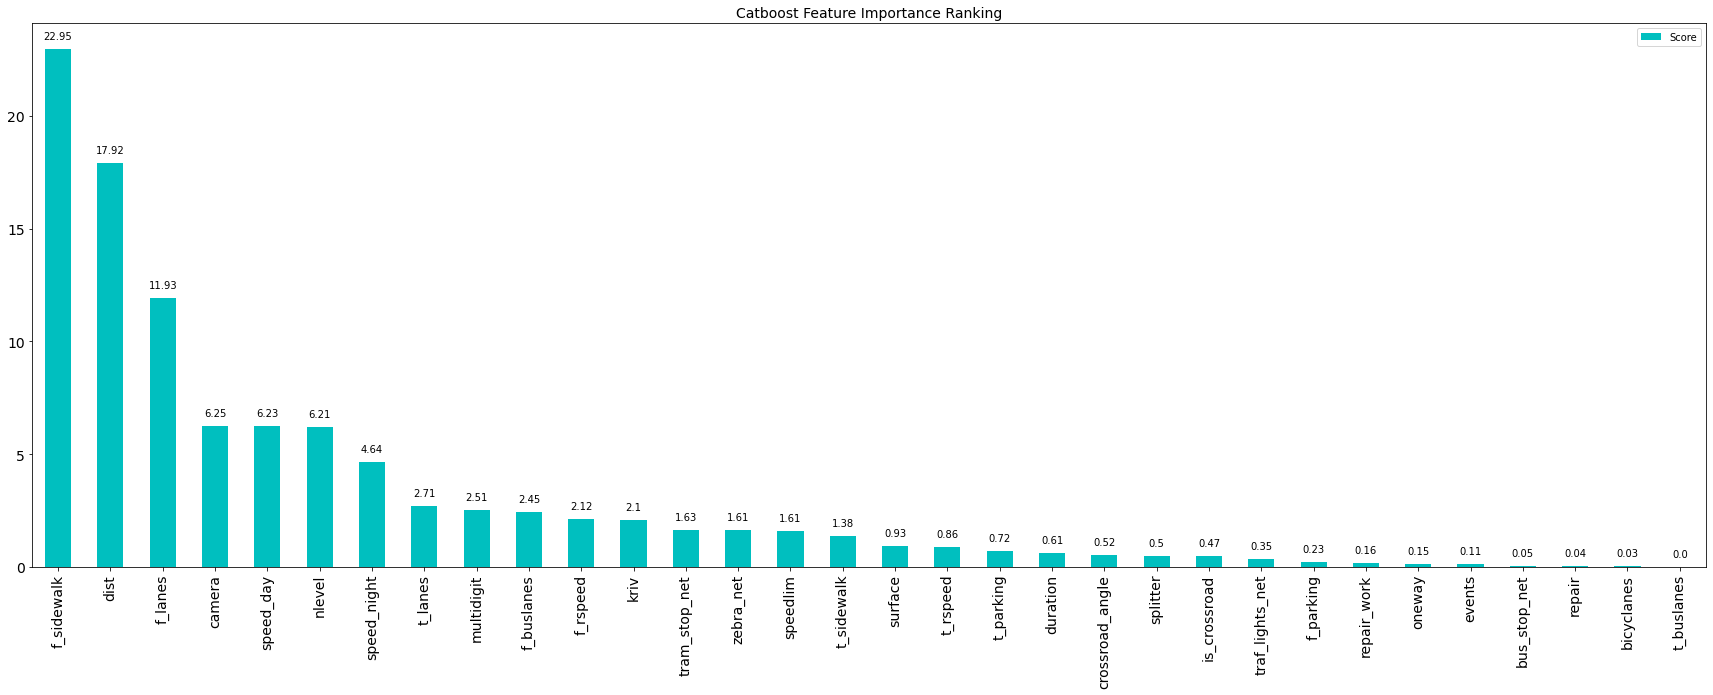

In [ ]:
feature_score = pd.DataFrame(list(zip(one_hot.dtypes.index, feat_imp)),
                  columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (30,10)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c', fontsize=14)
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
temp = train_data.drop(['id', 'btf', 'typ_cod',
                          'obj_cod', 'lat_start', 'lon_start',
                          'lat_end', 'lon_end', 'lon_mean',
                          'lat_mean'], axis=1).corr().sort_values('victims')
temp['victims'].head(10)

nlevel       -0.185685
t_sidewalk   -0.122117
f_sidewalk   -0.121149
t_parking    -0.120749
f_parking    -0.104020
t_lanes      -0.058129
duration     -0.017736
surface      -0.017241
bicyclanes   -0.003137
kriv         -0.002525
Name: victims, dtype: float64

In [ ]:
temp['victims'].tail(10)

splitter      0.067577
zebra_net     0.073593
camera        0.100911
f_lanes       0.114945
f_buslanes    0.126306
speedlim      0.136598
oneway        0.142070
multidigit    0.163097
f_rspeed      0.171848
victims       1.000000
Name: victims, dtype: float64

**Главные факторы, влияющие на аварийность участка**
1. dist - длина участка. Предположительно, данный фактор оказывает большое влияние, так как, чем длиннее участок, тем больше шанс того, что дтп придется на этот участок.
2. obj_cod - идентификатор ребра.
3. lon и lat - географические координаты участка
4. f\t_sidewalk - характеристика тротуаров. 28.8% дтп связано с наездом на пешехода.
5. speed_day\night - показатель дневной скорости с камер. 17.9% дтп, связанных с нарушением пдд водителями, возникают из-за нарушения скоростного режима.
6. kriv - кривизна участка (выведенная нами фича!!!). Показывает сложность участка дороги.
7. nlevel - категория ребра дороги.
8. camera - наличие камеры. Наличие камеры является мерой, противоборствующей наршению скоростного режима.
9. f\t_lanes - количество полос. Показывает сложность участка.
10. multidigit - отдельные ребра для каждого направления движения.
11. f/t_rspeed - расчетная среднесуточная скорость.
12. repair - ремонтные работы. Из-за них возникает сложность движения по участку дороги.
13. speedlim - ограничение скорости. Мера, успокаивающая движение.

**Рекомендации.**
А рекомендации можно и нужно почитать в нашей презентации!

https://datalens.yandex/i7i45sma3hz2d